# VQE algorithm study

## Work Flow

1. Construct Hamiltonian
   1. Mapping
   2. Tapering
   3. Grouping observables
2. Design circuit
   1. Select ansatz
   2. Transpile and optimize
3. Estimator or Sampler
4. Training (find minimum)
5. Error mitigation

In [4]:
from chemistry_problems import chemical_model
from tapering import Z2_tapering
from grouping import grouping_observables

from qiskit_aer.backends.aer_simulator import AerSimulator
from qiskit.circuit.library import NLocal, TwoLocal
from qiskit import transpile
from qiskit.providers.fake_provider import FakeMontreal
from huayi_providers.fake_huayi30 import FakeHuayi30

from qiskit.circuit.library import ExcitationPreserving, TwoLocal, PauliTwoDesign
from qiskit.circuit.library import CPhaseGate, CXGate

# Create the qubit-Hamiltonian for ·OH molecule

qubit_ham = chemical_model()

# Tapering with Z2 symmetry

tapered_ham = Z2_tapering(qubit_ham)
print(tapered_ham.num_qubits, "qubits remained after Z2 tapering")

# import fake backends

fakehuayi = FakeHuayi30()
fakemontreal = FakeMontreal()

# Choose ansatz

# ansatz_ep_linear = ExcitationPreserving(
#     num_qubits=tapered_ham.num_qubits, 
#     reps=1, 
#     mode='fsim', 
#     entanglement="linear",
#     insert_barriers=True,
#     flatten=True
#     )
# ansatz_ep_full = ExcitationPreserving(
#     num_qubits=tapered_ham.num_qubits, 
#     reps=1, 
#     mode='fsim', 
#     entanglement="full",
#     insert_barriers=True,
#     flatten=True
#     )
# print("=== Excitation Preserving Ansatz, linear ===")
# print(ansatz_ep_linear.draw(fold=-1))
# print("=== Excitation Preserving Ansatz, full ===")
# print(ansatz_ep_full.draw(fold=-1))


ansatz_sc = TwoLocal(
    num_qubits=tapered_ham.num_qubits,
    rotation_blocks=['x','rz'],
    entanglement_blocks=['cx'],
    entanglement = "linear",
    reps = 2,
    insert_barriers = True,
    initial_state = None,
    flatten = True,
)
print("=== Excitation Preserving Ansatz, linear ===")
print(ansatz_sc.draw(fold=-1))

ansatz_ion = TwoLocal(
    num_qubits=tapered_ham.num_qubits,
    rotation_blocks=['rx', 'ry'],
    entanglement_blocks=['cz',], # CPhase is currently not supported by Qiskit
    entanglement = "full",
    reps=2,
    insert_barriers = True,
    initial_state = None,
    flatten = True,
)
# ansatz_ion._flatten = True
print("=== Excitation Preserving Ansatz, full ===")
print(ansatz_ion.draw(fold=-1))



# Transpile circuit
# linear ansatz for superconductor
# full ansatz for ion trap

circ_sc = transpile(ansatz_sc, backend=fakemontreal,
                    basis_gates=fakemontreal.configuration().basis_gates, 
                    optimization_level=3)
circ_ion = transpile(ansatz_ion, backend=fakehuayi,
                    basis_gates=fakehuayi.configuration().basis_gates, 
                    optimization_level=3)

# circ_sc = transpile(ansatz_ep_linear, fakemontreal, optimization_level=3)
# circ_ion = transpile(ansatz_ep_full, fakehuayi, optimization_level=3)

print("=== Circuit for superconductor ===")
print("depth = {0}  num_params = {1}".format(circ_sc.depth(), circ_sc.num_parameters))
print(circ_sc.draw(fold=-1, idle_wires=False))
print("=== Circuit for trapped ions ===")
print("depth = {0}  num_params = {1}".format(circ_ion.depth(), circ_ion.num_parameters))
print(circ_ion.draw(fold=-1, idle_wires=False))


12 qubits in the Hamiltonian.
8 qubits remained after Z2 tapering
=== Excitation Preserving Ansatz, linear ===
     ┌───┐┌──────────┐ ░                                     ░ ┌───┐ ┌──────────┐ ░                                     ░ ┌───┐┌───────────┐
q_0: ┤ X ├┤ Rz(θ[0]) ├─░───■─────────────────────────────────░─┤ X ├─┤ Rz(θ[8]) ├─░───■─────────────────────────────────░─┤ X ├┤ Rz(θ[16]) ├
     ├───┤├──────────┤ ░ ┌─┴─┐                               ░ ├───┤ ├──────────┤ ░ ┌─┴─┐                               ░ ├───┤├───────────┤
q_1: ┤ X ├┤ Rz(θ[1]) ├─░─┤ X ├──■────────────────────────────░─┤ X ├─┤ Rz(θ[9]) ├─░─┤ X ├──■────────────────────────────░─┤ X ├┤ Rz(θ[17]) ├
     ├───┤├──────────┤ ░ └───┘┌─┴─┐                          ░ ├───┤┌┴──────────┤ ░ └───┘┌─┴─┐                          ░ ├───┤├───────────┤
q_2: ┤ X ├┤ Rz(θ[2]) ├─░──────┤ X ├──■───────────────────────░─┤ X ├┤ Rz(θ[10]) ├─░──────┤ X ├──■───────────────────────░─┤ X ├┤ Rz(θ[18]) ├
     ├───┤├──────────┤ ░      └───┘┌─┴─┐   

## Ideal Circuits

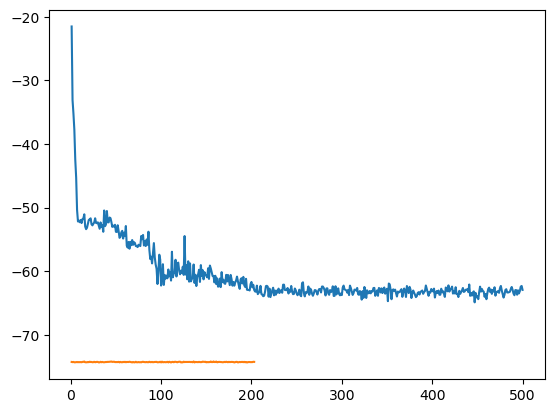

In [59]:
import random
from numpy import pi
import numpy as np
from qiskit_aer.primitives import Estimator
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import OptimizerResult, COBYLA, SLSQP, L_BFGS_B
from matplotlib.pyplot import *

converge_cnts = np.empty([2], dtype=object)
converge_vals = np.empty([2], dtype=object)

for j, circ in enumerate([circ_ion, circ_sc]):

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        print("iter {0}  \tvalue = {1}".format(eval_count, mean))


    params = [0.2*pi*random.random() for i in range(circ.num_parameters)]

    vqe_solver = VQE(Estimator(), circ, COBYLA(maxiter=500),
                    initial_point=params,
                    callback=store_intermediate_result)

    vqe_results = vqe_solver.compute_minimum_eigenvalue(operator=tapered_ham)

    print(vqe_results)

    converge_cnts[j] = np.asarray(counts)
    converge_vals[j] = np.asarray(values)

plot(converge_cnts[0], converge_vals[0])
plot(converge_cnts[1], converge_vals[1])

## Noisy Circuits

In [46]:
from qiskit_aer.noise.noise_model import NoiseModel
from qiskit_aer.primitives import Estimator, Sampler
from scipy.optimize import minimize
from numpy import pi 
import random

from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import OptimizerResult, COBYLA, SLSQP

estimator = Estimator(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU',
        'noise_model': NoiseModel.from_backend(fakemontreal)
    },
    run_options = {
        'shots': 2000,
        'seed': 114514,
    },
    skip_transpilation=True
)

sampler = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU'
    },
    run_options = {
        'shots': 2000,
        'seed': 114514,
    },
    transpile_options = {
        'seed_transpiler':114514
    }
)

def expect_hamiltonian(params, estimator, circuit, grouped_observables):
    
    final_circuit = circuit.copy()
    #add the measurement operations
    for i, el in enumerate(grouped_observables):
        if el == 'I':
            #no measurement for identity
            continue
        elif el == 'Z':
            final_circuit.measure(i, i)
        elif el == 'X':
            final_circuit.h(i)
            final_circuit.measure(i, i)
        elif el == 'Y':
            final_circuit.sdg(i)
            final_circuit.h(i)
            final_circuit.measure(i, i)

    return final_circuit


    result = 0.0
    for observables in grouped_observables:
        job = estimator.run(circuit.assign_parameters(params), observables)
        result += job.result().values[0]
    print(result)
    return result


circ_montreal = transpile(circ_sc, fakemontreal)
params = [2*pi**random.random() for i in range(circ_montreal.num_parameters)]


# Grouping Observables

grouped_obs_sc = grouping_observables(circ_montreal, tapered_ham)

Optimum = minimize(expect_hamiltonian,
                   params,
                   args=(estimator, circ_montreal, grouped_obs_sc),
                   method='COBYLA',
                   options={"maxiter":5000,"rhobeg":pi})

-4.480415411970151
-4.480415411970151


KeyboardInterrupt: 

In [43]:
estimator.run(circ_montreal, grouped_obs_sc[1], params).result()

EstimatorResult(values=array([-0.0016985]), metadata=[{'shots': 2000, 'variance': 0.18015697801331373, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [2, 3, 5, 8, 11, 12, 13, 14], 'device': 'CPU', 'remapped_qubits': True, 'num_qubits': 8, 'num_clbits': 8, 'time_taken': 0.0888588, 'input_qubit_map': [[2, 0], [11, 4], [3, 1], [13, 6], [5, 2], [8, 3], [12, 5], [14, 7]], 'max_memory_mb': 16108, 'measure_sampling': False, 'noise': 'kraus', 'parallel_shots': 16, 'parallel_state_update': 1, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': True, 'threshold': 14, 'max_fused_qubits': 2, 'applied': False}}, {'batched_shots_optimization': False, 'required_memory_mb': 1, 'method': 'statevector', 'active_input_qubits': [2, 3, 5, 8, 11, 12, 13, 14], 'device': 'CPU', 'remapped_qubits': True, 'num_qubits': 8, 'num_clbits': 8, 'time_taken': 0.0828604, 'input_qubit_map': [[2, 0], [11, 4], [3

In [ ]:
circ_montreal.assign_parameters()